BLOQUE 1 – importaciones y datos

In [1]:
# Análisis de viralización en YouTube: exploración de franjas horarias, categorías, y antigüedad de los canales
# Datos procesados a partir de 'youtube_master_dataset.csv'

import pandas as pd
import altair as alt
import numpy as np

# Altair sin límite de filas
alt.data_transformers.disable_max_rows()

# Cargar y depurar datos en una sola pasada
df = (
    pd.read_csv("data/youtube_master_dataset.csv")
      .dropna(subset=["category_name", "time_to_trend_hours", "time_frame"])
      .assign(success_under_24h=lambda d: d["time_to_trend_hours"] < 24)
)

# Proporción de vídeos que entran en Tendencias (< 24 h) por franja y categoría
grouped = (
    df.groupby(["time_frame", "category_name"])
      .agg(success_rate=("success_under_24h", "mean"),
           count=("video_id", "count"))
      .reset_index()
      .assign(success_rate=lambda d: d["success_rate"] * 100)   # en %
)

BLOQUE 2 – figura 1 (heat-map)

In [2]:
# Ordenar time_frame cronológicamente (ej. '1:00 to 1:59' → 1)

ordered_franjas = sorted(
    grouped["time_frame"].unique(), 
    key=lambda x: int(x.split(":")[0])
)

# Figura 1: Heatmap de % de éxito en entrar en Tendencias (<24h), por categoría y franja horaria

heatmap = alt.Chart(grouped).mark_rect().encode(
    x=alt.X(
        "time_frame:N",
        title="Franja horaria local",
        sort=ordered_franjas,
        axis=alt.Axis(labelFontSize=12, titleFontSize=14)
    ),
    y=alt.Y(
        "category_name:N",
        title="Categoría del vídeo",
        axis=alt.Axis(labelFontSize=12, titleFontSize=14, labelAngle=0)
    ),
    color=alt.Color(
        "success_rate:Q",
        title="% éxito en Tendencias (<24h)",
        scale=alt.Scale(scheme="blues"),
        legend=alt.Legend(
            titleFontSize=13,
            labelFontSize=12,
            titleLimit=200,
            padding=10,
            offset=10
        )
    ),
    tooltip=[
        alt.Tooltip("time_frame:N", title="Franja"),
        alt.Tooltip("category_name:N", title="Categoría"),
        alt.Tooltip("success_rate:Q", format=".1f", title="% éxito"),
        alt.Tooltip("count:Q", title="Nº de vídeos")
    ]
).properties(
    title="Éxito en viralización según franja horaria y categoría",
    width=700,
    height=400
).configure_title(
    fontSize=18,
    offset=20
).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelPadding=8,
    titlePadding=10
).configure_legend(
    labelFontSize=12,
    titleFontSize=13,
    titleLimit=200,
    padding=10,
    offset=10
)

heatmap

C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [3]:
heatmap.save('docs/heatmap_exito_por_franja_y_categoria.html')

C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


BLOQUE 3 – figura 2 (barras)

C:\Users\Coni\AppData\Local\Temp\ipykernel_13108\3618257769.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


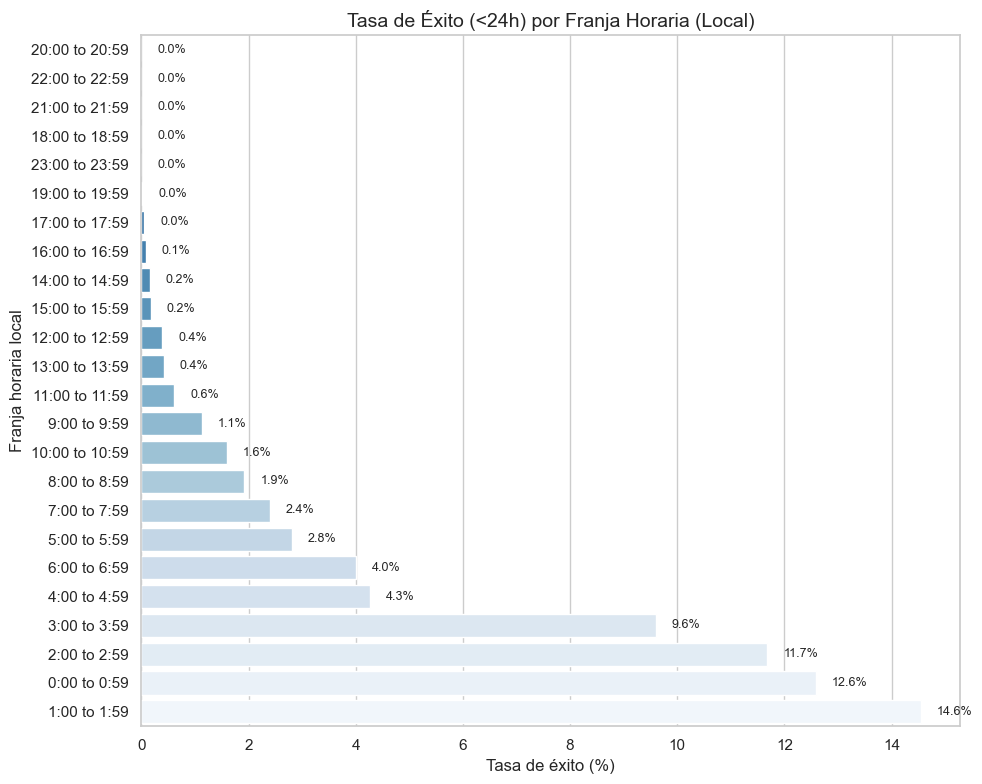

In [4]:
# Calcular total de vídeos y vídeos con éxito por franja
franjas_exito = (
    grouped
    .assign(success_count=lambda d: (d["success_rate"] / 100) * d["count"])
    .groupby("time_frame")
    .agg(
        total_videos=("count", "sum"),
        total_successes=("success_count", "sum")
    )
    .reset_index()
)

# Calcular éxito ponderado (tasa total de éxito en esa franja)
franjas_exito["global_success_rate"] = 100 * franjas_exito["total_successes"] / franjas_exito["total_videos"]

# Ordenar de mayor a menor
franjas_ordenadas = franjas_exito.sort_values(by="global_success_rate", ascending=False)

# Figura 2: Barras de tasa de éxito global por franja horaria (ponderada por número de vídeos)

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de estilo
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Ordenamos por tasa de éxito ascendente
franjas_ordenadas_sorted = franjas_ordenadas.sort_values(by="global_success_rate", ascending=True)

# Gráfico de barras verticales
ax = sns.barplot(
    data=franjas_ordenadas_sorted,
    y="time_frame",
    x="global_success_rate",
    palette="Blues_r"
)

# Etiquetas y título
ax.set_title("Tasa de Éxito (<24h) por Franja Horaria (Local)", fontsize=14)
ax.set_xlabel("Tasa de éxito (%)", fontsize=12)
ax.set_ylabel("Franja horaria local", fontsize=12)

# Mostrar los valores exactos en las barras
for i, row in franjas_ordenadas_sorted.iterrows():
    ax.text(
        x=row["global_success_rate"] + 0.3,
        y=franjas_ordenadas_sorted.index.get_loc(i),
        s=f"{row['global_success_rate']:.1f}%",
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.savefig('docs/barras_exito_franja.png', dpi=100, bbox_inches='tight')
plt.show()

In [5]:
plt.savefig('docs/barras_exito_franja.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

BLOQUE 4 – figura 3 (scatter)

In [6]:
# 1) Fuerza a Altair a incrustar TODO el dataset en el HTML
alt.data_transformers.enable('default', max_rows=None)

# ─── VISUALIZACIÓN 2: Scatterplot por antigüedad del canal ────────────────────

# Filtrar por categoría "Music" y filas no nulas
df_music = (
    df[df["category_name"] == "Music"]
    .dropna(subset=["channel_subscribers", "views", "channel_age_days"])
    .copy()
)

# Métricas y transformaciones
df_music["views_per_hour_first24h"] = df_music["views"] / 24
df_music["log_subscribers"] = np.log10(df_music["channel_subscribers"] + 1)
df_music["log_views_24h"] = np.log10(df_music["views_per_hour_first24h"] + 1)

# Clasificar antigüedad
df_music["age_group"] = pd.cut(
    df_music["channel_age_days"],
    bins=[0, 365, 1095, np.inf],
    labels=["<1 año", "1-3 años", ">3 años"]
)

# DataFrame final
df_altair = df_music[
    ["channel_title", "title", "log_subscribers", "log_views_24h", "age_group"]
].dropna(subset=["age_group"])

# Colores
color_dict = {"<1 año": "#1f77b4", "1-3 años": "#2ca02c", ">3 años": "#d62728"}

# Selección
selection = alt.selection_point(
    fields=["age_group"], bind="legend", toggle=True, clear=False, value="<1 año"
)

# Gráfico
chart = (
    alt.Chart(df_altair)
    .mark_circle(size=30)
    .encode(
        x=alt.X("log_subscribers", title="Log10(Nº de suscriptores)", scale=alt.Scale(zero=False)),
        y=alt.Y("log_views_24h", title="Log10(Reproducciones en las primeras 24 h)", scale=alt.Scale(zero=False)),
        color=alt.Color(
            "age_group:N",
            scale=alt.Scale(domain=list(color_dict), range=list(color_dict.values())),
            legend=alt.Legend(title="Antigüedad del canal")
        ),
        opacity=alt.condition(selection, alt.value(1), alt.value(0.1)),
        tooltip=["channel_title", "title", "age_group"]
    )
    .add_params(selection)
    .properties(
        title="Relación entre suscriptores y visualizaciones según antigüedad del canal",
        width=600, height=400
    )
)

# 2) Guardar en docs/ con datos incrustados
chart.save('docs/scatter_antiguedad_vs_reproducciones.html')

# 3) Mostrar en notebook (opcional)
chart

C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:3

alt.Chart(...)

BLOQUE 5 – figura 4 (dot-plot) y figura 5 (barras)

In [7]:
# 1. Convertir fechas y extraer año
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df['year'] = df['publish_date'].dt.year

# 2. Filtrar datos entre 2017 y 2018
df_filtered = df[(df['year'] >= 2017) & (df['year'] <= 2018)]

# 3. Agrupar por año y categoría
agg_trend_time = (
    df_filtered
    .groupby(['year', 'category_name'])
    .agg(
        n_videos=('video_id', 'count'),
        avg_trend_hours=('time_to_trend_hours', 'mean')
    )
    .reset_index()
    .dropna(subset=['avg_trend_hours'])
)

# Figura 4: Tiempo medio hasta entrar en Tendencias por categoría y año (dot plot)

# 4. Dot plot
dot_plot = alt.Chart(agg_trend_time).mark_circle().encode(
    x=alt.X(
        'avg_trend_hours:Q',
        title='Tiempo medio hasta viralización (h)',
        axis=alt.Axis(labelFontSize=12, titleFontSize=14, labelPadding=8, titlePadding=10)
    ),
    y=alt.Y(
        'category_name:N',
        title='Categoría',
        sort='-x',
        axis=alt.Axis(labelFontSize=12, titleFontSize=14, labelPadding=8, titlePadding=10)
    ),
    color=alt.Color(
        'year:O',
        title='Año',
        legend=alt.Legend(labelFontSize=12, titleFontSize=13, padding=10, offset=10)
    ),
    size=alt.Size('n_videos:Q', title='Nº vídeos'),
    tooltip=[
        alt.Tooltip('category_name:N', title='Categoría'),
        alt.Tooltip('year:O', title='Año'),
        alt.Tooltip('n_videos:Q', title='Nº vídeos'),
        alt.Tooltip('avg_trend_hours:Q', title='Tiempo medio (h)', format='.1f')
    ]
).properties(
    title='Velocidad de viralización por categoría (2017–2018)',
    width=700,
    height=400
)

# Figura 5: Número total de vídeos virales por categoría y año (barras)

# 5. Bar chart
bar_chart = alt.Chart(agg_trend_time).mark_bar().encode(
    x=alt.X(
        'n_videos:Q',
        title='Número de vídeos',
        axis=alt.Axis(labelFontSize=12, titleFontSize=14, labelPadding=8, titlePadding=10)
    ),
    y=alt.Y(
        'category_name:N',
        title='Categoría',
        sort='-x',
        axis=alt.Axis(labelFontSize=12, titleFontSize=14, labelPadding=8, titlePadding=10)
    ),
    color=alt.Color(
        'year:O',
        title='Año',
        legend=alt.Legend(labelFontSize=12, titleFontSize=13, padding=10, offset=10)
    ),
    tooltip=[
        alt.Tooltip('category_name:N', title='Categoría'),
        alt.Tooltip('year:O', title='Año'),
        alt.Tooltip('n_videos:Q', title='Nº vídeos')
    ]
).properties(
    title='Volumen de vídeos virales por categoría y año',
    width=700,
    height=200
)

# 6. Gráfico combinado con configuración global
combined_chart = (
    dot_plot & bar_chart
).configure_title(
    fontSize=18,
    offset=20
).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelPadding=8,
    titlePadding=10
).configure_legend(
    labelFontSize=12,
    titleFontSize=13,
    padding=10,
    offset=10
)

combined_chart

C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [8]:
combined_chart.save('docs/viralizacion_por_categoria_y_anio.html')

C:\Users\Coni\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
